In [10]:
from SnackTrackDataset import SnackTrackDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil

In [2]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 64 * 64, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(128, 4)  # Output for 4 classes
        )

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
# prepare dataset with participant split
# Load metadata (example dataframe)
metadata_file = "/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/spectrograms/metadata.csv"  # Path to metadata file
metadata = pd.read_csv(metadata_file)

# Group by participant
participants = metadata['participant'].unique()

# Split participants into train/val
train_participants, val_participants = train_test_split(participants, test_size=0.2, random_state=42)

# Get indices for train/val participants
train_indices = metadata[metadata['participant'].isin(train_participants)].index.tolist()
val_indices = metadata[metadata['participant'].isin(val_participants)].index.tolist()

# Create full dataset
full_dataset = SnackTrackDataset(metadata)

# Create Subsets for train/val
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [ ]:
# prepare dataset with random split
# Dataset and DataLoader
dataset = SnackTrackDataset(metadata_file)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Parameters
batch_size = 16
learning_rate = 0.001
num_epochs = 10

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize model, loss, optimizer
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    # perform training followed by validation
    for mode, loader, num_samples in [
        ("train", train_loader, train_size),
        ("val", val_loader, val_size)
    ]:
        # progress bar setup
        num_batches = int(ceil(num_samples / batch_size))
        pbar = tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train()
        else:
            model.eval()

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0

        for spectrograms, labels in loader:
            # move tensors to the correct device
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            # forward step of model
            outputs = model(spectrograms)
            # loss calculation
            loss = criterion(outputs, labels)

            # calculate metrix for progress bar
            num_batch_samples = len(spectrograms)
            runningLoss += loss.item()
            correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += num_batch_samples

            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples
            })
            
            # if in train mode update weights
            if mode == "train":
                # backward step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()


# Train the model
#train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

val epoch 9: 100%|██████████| 2/2 [00:12<00:00,  6.10s/it, loss=0.0103, accuracy=0.92] 


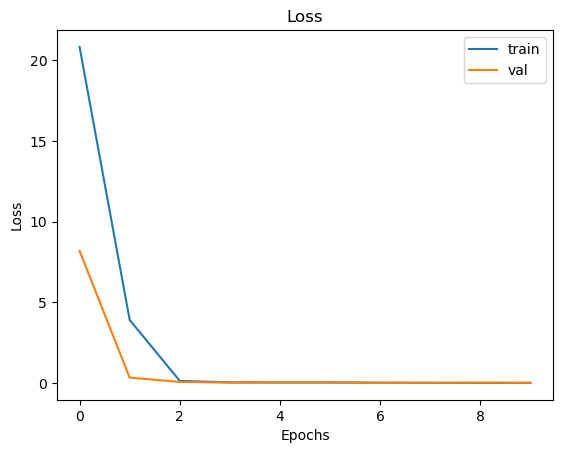

In [4]:
plt.title("Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

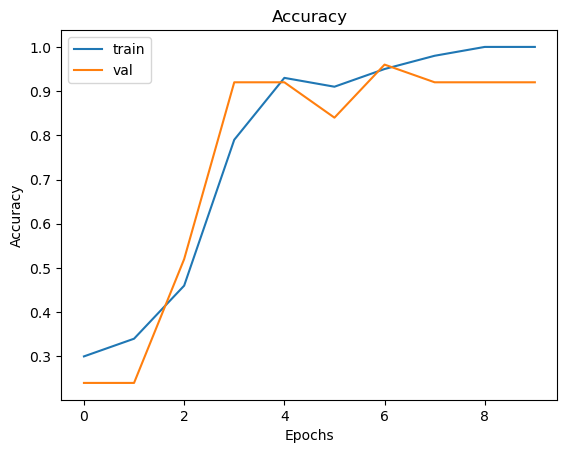

In [5]:
plt.title("Accuracy")
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [6]:
torch.save(model.state_dict(), 'model.pth')

In [7]:
#model = CNNModel()
#model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()

spectrogram_path = '/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/spectrograms/participant01/resting1.npy'
spectrogram = np.load(spectrogram_path)
spectrogram = np.expand_dims(spectrogram, axis=0)
spectrogram = np.expand_dims(spectrogram, axis=0)
spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
spectrogram = spectrogram.to(device)

with torch.no_grad():
    outputs = model(spectrogram)
    preds = outputs.argmax(dim=1)

predicted_class = preds.item()
print(f"Predicted class: {predicted_class}")

Predicted class: 3
